In [1]:
# Sample to be processed
study = 'scmznos_valtor_combined'


In [2]:
# Input/output/resource directories
place = 'nemo'
scratchdir = "/plus/scratch/users/scott/projects/scmznos_valtor"
rawdir = f'{scratchdir}/raw_data'
outdir = f'{scratchdir}/project_results'
datadir = f'{scratchdir}/resources'
commonsdir = '/plus/data/@data_scott/common_resources'
syncdir='/home/scott/Sync/scmznos_sync'


In [3]:
# Load libraries
import os
import sklearn
import pickle
import pandas as pd
import numpy as np
import scipy
from scipy.sparse import csr_matrix
from scipy import io

import scanpy as sc
import anndata as ad
import pybiomart as pbm
import leidenalg as la
import scrublet as scr

import graphtools as gt
from pygsp import graphs, filters
import phate
import magic
import scprep
import sklearn
import meld

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import time
import natsort

# Package settings
sc.settings.autosave = False
sc.settings.figdir = f'{syncdir}/'
np.random.seed(42)
font = {'size'   : 14}
mpl.rc('font', **font)
mpl.rcParams['animation.embed_limit'] = 1000
mpl.rcParams['pdf.fonttype'] = 42


In [4]:
# Show loaded libraries
import session_info
session_info.show()

In [5]:
# Import sequence analysis tools
import pyranges as pr
import pybedtools
import Bio
import pysam


In [6]:
# Homemade utility functions
import pyFunctions
from pyFunctions.annotation import *


### Load cluster data

In [7]:
# Load GSPA gene module annotation
cluster_annotation = pd.read_csv(f'{outdir}/scMZnps_HVG_cluster_annotation.csv', index_col=0)
cluster_annotation['Cluster'][cluster_annotation['Cluster'].isna()] = 'Silent'
cluster_annotation['Cluster'] = cluster_annotation['Cluster'].str.removeprefix('#')
with open(f'{outdir}/HVG_cluster_order.pkl', 'rb') as f:
    cluster_order = pickle.load(f)
cluster_order = [i.removeprefix('#') for i in cluster_order] + ['Silent']

cluster_annotation['Cluster'] = cluster_annotation['Cluster'].astype('category')
cluster_annotation['Cluster'] = cluster_annotation['Cluster'].cat.reorder_categories(cluster_order)
cluster_annotation


/tmp/ipykernel_450050/3701530852.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  cluster_annotation = pd.read_csv(f'{outdir}/scMZnps_HVG_cluster_annotation.csv', index_col=0)
/tmp/ipykernel_450050/3701530852.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.or

gene_ids       gene_symbol           EnsemblID  \
crebl2            ENSDARG00000104049            crebl2  ENSDARG00000104049   
msgn1             ENSDARG00000070546             msgn1  ENSDARG00000070546   
si:ch211-51e12.7  ENSDARG00000045914  si:ch211-51e12.7  ENSDARG00000045914   
mrps10            ENSDARG00000045913            mrps10  ENSDARG00000045913   
tulp4a            ENSDARG00000045911            tulp4a  ENSDARG00000045911   
...                              ...               ...                 ...   
CABZ01113599.1    ENSDARG00000108136    CABZ01113599.1  ENSDARG00000108136   
exosc3-1          ENSDARG00000104246          exosc3-1  ENSDARG00000104246   
CABZ01048453.1    ENSDARG00000104434    CABZ01048453.1  ENSDARG00000104434   
CABZ01048392.1    ENSDARG00000111876    CABZ01048392.1  ENSDARG00000111876   
cdo1              ENSDARG00000099389              cdo1  ENSDARG00000099389   

                                                        Description  \
crebl2            cAMP responsive element binding protein-like 2...   
msgn1               mesogenin 1 [Source:ZFIN;Acc:ZDB-GENE-030722-1]   
si:ch211-51e12.7  si:ch211-51e12.7 [Source:ZFIN;Acc:ZDB-GENE-030...   
mrps10            mitochondrial ribosomal protein S10 [Source:ZF...   
tulp4a            TUB like protein 4a [Source:ZFIN;Acc:ZDB-GENE-...   
...                                                             ...   
CABZ01113599.1                                                  NaN   
exosc3-1          wu:fc33b09 [Source:NCBI gene (formerly Entrezg...   
CABZ01048453.1                                                  NaN   
CABZ01048392.1                                                  NaN   
cdo1              cysteine dioxygenase, type I [Source:ZFIN;Acc:...   

                         Biotype  EntrezGeneID               ZFIN_ID  \
crebl2            protein_coding      436975.0   ZDB-GENE-040718-456   
msgn1             protein_coding      360135.0     ZDB-GENE-030722-1   
si:ch211-51e12.7  protein_coding      336335.0  ZDB-GENE-030131-8279   
mrps10            protein_coding      565937.0    ZDB-GENE-040914-39   
tulp4a            protein_coding      557730.0   ZDB-GENE-060503-215   
...                          ...           ...                   ...   
CABZ01113599.1    protein_coding           NaN                   NaN   
exosc3-1          protein_coding      324574.0                   NaN   
CABZ01048453.1    protein_coding           NaN                   NaN   
CABZ01048392.1    protein_coding   110438503.0                   NaN   
cdo1              protein_coding      393714.0  ZDB-GENE-040426-1704   

                       ZFIN_symbol      MouseEnsemblID MouseGeneSymbol  ...  \
crebl2                      crebl2  ENSMUSG00000032652          Crebl2  ...   
msgn1                        msgn1  ENSMUSG00000047002           Msgn1  ...   
si:ch211-51e12.7  si:ch211-51e12.7                 NaN             NaN  ...   
mrps10                      mrps10  ENSMUSG00000034729          Mrps10  ...   
tulp4a                      tulp4a  ENSMUSG00000034377           Tulp4  ...   
...                            ...                 ...             ...  ...   
CABZ01113599.1                 NaN  ENSMUSG00000040325           Dcaf1  ...   
exosc3-1                       NaN  ENSMUSG00000028322          Exosc3  ...   
CABZ01048453.1                 NaN  ENSMUSG00000029250          Polr2b  ...   
CABZ01048392.1                 NaN  ENSMUSG00000025898         Cwf19l2  ...   
cdo1                          cdo1  ENSMUSG00000033022            Cdo1  ...   

                 MZnps_2.5hpf MZnps_3hpf MZnps_3.5hpf  MZnps_4hpf  \
crebl2              -1.327899  -1.577992    -1.156429   -0.831662   
msgn1               -0.430963  -0.470814    -0.482001   -0.381351   
si:ch211-51e12.7    -0.688686  -0.741290    -0.757083   -0.618424   
mrps10              -2.225115  -1.920836    -1.326585   -1.204190   
tulp4a              -1.500882  -1.341888    -1.420992   -1.032009   
...       

In [8]:
# Create color matrix
with open(f'{outdir}/HVG_cluster_order.pkl', 'rb') as f:
    cols_hex = pickle.load(f)

cols_hex = cols_hex + ['grey']

colours = pd.DataFrame({'Cluster': cols_hex})
colours.index = cluster_order
colours

Cluster
fed481  #fed481
9e0142  #9e0142
dd4a4c  #dd4a4c
f98e52  #f98e52
86cfa5  #86cfa5
ffffbe  #ffffbe
3d95b8  #3d95b8
5e4fa2  #5e4fa2
d6ee9b  #d6ee9b
Silent     grey

### Output a bedfile of ranges for visualising accessibility around promoters with deeptools

In [9]:
# Use Liyuns canonical start sit|es (TSS)
atac_genes = pd.read_csv(f'{datadir}/20240312_Liyun_ATAC_genes.csv')
atac_genes

chr  CTSS_coord                gene          gene_name  WT_4h_CiT_exon  \
0        4    42645880  ENSDARG00000117206            RF00003      255.054273   
1       22     1586059  ENSDARG00000117185  si:ch211-255f4.11     1668.407743   
2        4    41343089  ENSDARG00000117166            RF00003      619.797631   
3        4    44672985  ENSDARG00000117156     si:dkey-7j22.4      343.330059   
4        4    50463607  ENSDARG00000117132         BX663613.1      299.299432   
...    ...         ...                 ...                ...             ...   
31356   14    14992908  ENSDARG00000117200         BX119314.1       26.317189   
31357   10    34107919  ENSDARG00000117202            pimr144        3.902234   
31358   19    17373631  ENSDARG00000117203            RF00424        0.000000   
31359   12    47774807  ENSDARG00000117204         LO017725.1        0.000000   
31360    4    32291755  ENSDARG00000117208            RF00026       42.504261   

       MZ_NOS_4h_CiT_exon    gene_biotype    category  intron_length  \
0              383.950513           snRNA  Unaffected              0   
1              837.989763  protein_coding  Unaffected            251   
2              372.395597           snRNA  Unaffected              0   
3              504.335526  protein_coding  Unaffected           5249   
4              176.105898  protein_coding  Unaffected          14483   
...                   ...             ...         ...            ...   
31356           27.094604  protein_coding         NaN           1993   
31357            4.329016  protein_coding         NaN          16187   
31358            0.000000          scaRNA         NaN              0   
31359            0.000000  protein_coding         NaN            342   
31360          413.473875           snRNA         NaN              0   

       WT_4h_CiT_intron  MZ_NOS_4h_CiT_intron               enhancer  \
0              0.000000              0.000000                    NaN   
1            407.739532              0.000000                    NaN   
2              0.000000              0.000000                    NaN   
3            376.302651            194.700373                    NaN   
4             89.743237             34.616432                    NaN   
...                 ...                   ...                    ...   
31356          0.000000              0.000000                    NaN   
31357          3.793512              5.956225                    NaN   
31358          0.000000              0.000000                    NaN   
31359          0.000000              0.000000  peak_24198/peak_24199   
31360          0.000000              0.000000                    NaN   

                                                     seq  
0      GGGTTGCTGGCCCATTCCCCATGCTCGGTGGCTGGGCATCACCGCC...  
1      CTTTAATAGCATATTGTGTCACCTACAGGATATAACACATGATGTT...  
2      GGGGAATTCGCAGGGGTCAGCGTGGCCGGAGTGCAATGGCCAAGCC...  
3      CAGCAGGTACATAATTTAGCACTGAATAAAAAAACTAACTTTAATC...  
4      TTTTGCGCTCCACACTTCTATCCAGTAGGTGGCGGGAATGCACCAT...  
...                                                  ...  
31356  CGTAAGTTATTTAGTGTGTTTTTAACAATTTTCATAAGAAATAACA...  
31357  GCCATTGTATCACTGTACTGTTGAATCGCAGAAAGTACTGAACTAC...  
31358  ACTTCAAGCTAATCAGGACTTGTTAGTTGGTCATGTGCTGATGCTC...  
31359  GGTAACCTCTCCTCCACGCCTGCAGCAGGTTCTTCCAGACCCCGAA...  
31360  CGGCATACAAGTGGGAACATGGCTCTCCAGGTCCCACCACCTTGGA...  

[31361 rows x 13 columns]

In [10]:
# Create beds
for clust in cluster_order:
    if os.path.exists(f'{outdir}/deeptools') == False:
                os.mkdir(f'{outdir}/deeptools')

    mod_genes = cluster_annotation[cluster_annotation['Cluster'] == clust].EnsemblID.to_list()
    print(f'Number promoter in module {clust}:{len(mod_genes)}')

    module_bed = atac_genes[atac_genes.gene.isin(mod_genes)][["chr", "CTSS_coord", "CTSS_coord", "gene_name", "MZ_NOS_4h_CiT_exon"]]
    # module_bed = cluster_annotation[cluster_annotation['Cluster'] == clust][["Chromosome", 'Start', 'Start', 'names', 'logOR']]
    print(f'Number promoter in module {clust} and ATAC list:{module_bed.shape[0]}')

    module_bed['strand'] = '.'
    module_bed.columns = ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand']
    module_bed['chromEnd'] = module_bed['chromEnd'].astype(int) + 1
    module_bed['score'] = 0
    module_bed = module_bed.reset_index(drop=True)
    module_bed[['chromStart', 'chromEnd', 'score']] = module_bed[['chromStart', 'chromEnd', 'score']].astype(int)
    module_bed.to_csv(f'{outdir}/deeptools/scMZnps_HVG_cluster_{clust}_genes_bed.bed', header=False, index=False, sep='\t')


Number promoter in module fed481:625
Number promoter in module fed481 and ATAC list:623
Number promoter in module 9e0142:1661
Number promoter in module 9e0142 and ATAC list:1654
Number promoter in module dd4a4c:796
Number promoter in module dd4a4c and ATAC list:787
Number promoter in module f98e52:498
Number promoter in module f98e52 and ATAC list:494
Number promoter in module 86cfa5:637
Number promoter in module 86cfa5 and ATAC list:633
Number promoter in module ffffbe:831
Number promoter in module ffffbe and ATAC list:827
Number promoter in module 3d95b8:802
Number promoter in module 3d95b8 and ATAC list:796
Number promoter in module 5e4fa2:1054
Number promoter in module 5e4fa2 and ATAC list:1049
Number promoter in module d6ee9b:1131
Number promoter in module d6ee9b and ATAC list:1123
Number promoter in module Silent:901
Number promoter in module Silent and ATAC list:846


In [11]:
# # Create beds
# for mod in manual_order:
#     mod_genes = timecourse_gspa_var[timecourse_gspa_var.Clusters_fine == str(mod)].gene_id.to_list()
#     module_bed = atac_genes[atac_genes.gene.isin(mod_genes)][["chr", "CTSS_coord", "CTSS_coord", "gene_name", "MZ_NOS_4h_CiT_exon"]]
#     module_bed['strand'] = '.'
#     module_bed.columns = ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand']
#     module_bed['chromEnd'] = module_bed['chromEnd'].astype(int) + 1
#     module_bed['score'] = 0
#     module_bed = module_bed.reset_index(drop=True)
#     module_bed[['chromStart', 'chromEnd', 'score']] = module_bed[['chromStart', 'chromEnd', 'score']].astype(int)
#     module_bed.to_csv(f'{outdir}/deeptools/GSPA_module{mod}_genes_bed.bed', header=False, index=False, sep='\t')


In [12]:
# # List of modules for plotting
# COI_list = {}
# for it in module_clusters.Module_cluster.unique():
#     COI_list[it] = module_clusters[module_clusters.Module_cluster == it]['clust'].to_list()

In [13]:
# List of modules for plotting (all mods seperately)
COI_list = {}
for it in cluster_order:
    COI_list[it] = [it]

In [15]:
%%capture cap

for it in list(COI_list.keys()):
    COIs = COI_list[it]
    print(f"computeMatrix reference-point -S {rawdir}/GSE215956_WT_1k.bigwig {rawdir}/GSE215956_MZtriple_1k.bigwig {rawdir}/GSE188364_WT_oblong_bw.bigwig {rawdir}/GSE215956_MZtriple_oblong.bigwig {rawdir}/GSE188364_WT_dome_bw.bigwig {rawdir}/GSE215956_MZtriple_dome.bigwig \\")
    # print(f"computeMatrix reference-point -S {rawdir}/WT_REP_1_ATAC.bw {rawdir}/WT_REP_2_ATAC.bw {rawdir}/WT_REP_3_ATAC.bw {rawdir}/WT_REP_4_ATAC.bw {rawdir}/scNPS_REP_1_ATAC.bw {rawdir}/scNPS_REP_2_ATAC.bw {rawdir}/scNPS_REP_3_ATAC.bw \\")
    for mod in COIs:
        if mod == COIs[0]:
            print(f"-R {outdir}/deeptools/scMZnps_HVG_cluster_{mod}_genes_bed.bed \\")
        else:
            print(f"{outdir}/deeptools/scMZnps_HVG_cluster_{mod}_genes_bed.bed \\")
    print(f"--numberOfProcessors max/2 --referencePoint TSS -a 500 -b 500 --averageTypeBins mean -out {outdir}/deeptools/Deeptools_HVG_cluster_{it}.tab.gz")
    
    print(f"plotHeatmap -m {outdir}/deeptools/Deeptools_HVG_cluster_{it}.tab.gz --outFileNameMatrix {syncdir}/Deeptools_HVG_cluster_{it}_data.tab.gz -out {syncdir}/Deeptools_HVG_cluster_{it}.pdf --heatmapHeight 5 --colorMap Greens --refPointLabel TSS \\") 
    for mod in COIs:
        if mod == COIs[0]:
            print(f"--regionsLabel 'EM {mod}' \\")
        else :
            print(f"'EM {mod}' \\")
    print("--plotTitle 'ATAC signal' --sortRegions descend")

# Save the captured output to a text file
script_name = f'{outdir}/deeptools/Deeptools_HVG_cluster_promoter_plots.sh'
with open(script_name, 'w') as file:
    file.write(cap.stdout)

# Make script executable
! chmod 755 $script_name

In [16]:
%%sh
source /home/scott/scripts/scmultiome_curbos_scripts/multiome/bin/activate
/plus/scratch/users/scott/projects/scmznos_valtor/project_results/deeptools/Deeptools_HVG_cluster_promoter_plots.sh

#### To run first activate environment and them run script

source /home/scott/scripts/scmultiome_curbos_scripts/multiome/bin/activate  
/plus/scratch/users/scott/projects/scmznos_valtor/project_results/deeptools/Deeptools_HVG_cluster_promoter_plots.sh

### Get active enhancers for each module from Liyuns annotation

In [17]:
# Load data from Liyins paper
atac_peaks = pd.read_csv(f'{datadir}/20240312_Liyun_ATAC_peaks.csv')
atac_peaks

peak  chr     start       end    summit  WT_3_rep_avg  \
0            peak_8    1     17868     17966     17920      1.502159   
1           peak_9a    1     18571     18896     18664      1.484169   
2           peak_12    1     27558     27847     27666      1.536358   
3           peak_16    1     36592     36791     36691      1.778089   
4           peak_20    1     44083     44214     44148      0.894480   
...             ...  ...       ...       ...       ...           ...   
55965   peak_166402    9  56421284  56421433  56421379      1.867618   
55966  peak_166403b    9  56425966  56426110  56426071      1.176245   
55967   peak_166404    9  56427939  56428127  56428018      2.596806   
55968   peak_166408    9  56437704  56437837  56437800      0.846545   
55969   peak_166410    9  56452515  56452628  56452583      1.080229   

       MZnps_3_rep_avg  WT_rescue  MZnps_rescue  Nanog_rescue  ...  \
0             0.598221   1.991756      0.734989      0.367415  ...   
1             2.378412   1.873770      2.260675      1.661110  ...   
2             1.560771   2.192068      1.631030      2.099627  ...   
3             1.118060   2.525190      1.466560      1.490151  ...   
4             0.951350   1.103263      1.071673      0.956705  ...   
...                ...        ...           ...           ...  ...   
55965         1.973649   2.596763      2.216817      1.718619  ...   
55966         0.589178   1.353649      0.640750      0.415190  ...   
55967         3.937465   3.421492      4.153963      2.834622  ...   
55968         0.759659   0.948833      0.920855      0.655369  ...   
55969         0.760016   1.626483      0.798133      0.697960  ...   

       WT_sdt_mut  N-/P-/S-  N+/P-/S-  N-/P+/S-  N+/P+/S-  N-/P+/S+_ATAC  \
0        0.835635  0.825037  0.751096  0.851316  1.366838       0.995494   
1        2.399011  2.975243  2.491892  2.947948  2.462173       2.048067   
2        2.030410  2.007981  2.901021  2.026194  2.691190       1.619455   
3        2.281633  2.235209  2.353693  1.795996  2.777436       1.955889   
4        1.352044  1.298255  1.114576  1.016786  1.207094       1.062681   
...           ...       ...       ...       ...       ...            ...   
55965    1.513056  2.065408  1.757597  2.400141  1.454834       1.468106   
55966    0.742196  0.777171  1.067987  0.994542  0.398302       0.344810   
55967    2.616487  4.599406  2.763245  4.610956  2.858762       3.355177   
55968    0.498403  0.682550  0.761082  0.752349  0.585261       0.306268   
55969    0.362168  0.732790  0.961734  0.620395  0.677827       0.278289   

       N+/P+/S+  Category      Location  \
0      0.774732   Group 2  Other region   
1      2.652005     Other      Promoter   
2      2.507657     Other      Promoter   
3      2.224132     Other      Promoter   
4      1.215477     Other      Promoter   
...         ...       ...           ...   
55965  2.204794     Other  Other region   
55966  1.573671     Other  Other region   
55967  3.891692     Other  Other region   
55968  0.810297     Other  Other region   
55969  1.108488     Other  Other region   

                                                     seq  
0      ACAGTAAAGCAGAATTTACTAGAAGCTGCGGCAGCCTCAATCTTAC...  
1      AGGCCCCTGGTCTGAGAGCAGAAGTCGCCTCGTGAATTATTCTGTA...  
2      CGGCCATTTGAACTAGAACCGCCACTGCCTCAGACAGGATCATTAG...  
3      CTCTCCTCTGCTCTTCGTCGCGCTTCTCTGGTTTGAAATCTGCTCT...  
4      CGGAGAGTGATGGAGAAACTGCGCGAACTGAACCCCTCATGACCAG...  
...                                                  ...  
55965  AGAGAAGCTGGAGCTGAATGCTGGAATATCTCTGGTCTGCACAGAG...  
55966  GCTGCTGGCCAGCTAAACCAATCAAACACCCCAGAATGAGCAAATG...  
55967  CACTCACACAAACACACACACACACCTGCACTGCTGCTGAAGGTGA...  
55968  AGAACCACCACACACTGCTGGGAGCCGCTGGATGAGGGCCGGGTCG...  
55969  TGCTCATCATCCTCATCCCAGCGCTTGTGTGTTGCTGCTGCACACA...  

[55970 rows x 33 columns]

In [18]:
# Create bed file of summits
peaks_bed = atac_peaks[['chr', 'summit', 'summit', 'peak', 'MZnps_3_rep_avg']]
peaks_bed['strand'] = '.'
peaks_bed.columns = ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand']
peaks_bed['chromStart'] = peaks_bed['chromStart'].astype(int) - 100
peaks_bed['chromEnd'] = peaks_bed['chromEnd'].astype(int) + 100
peaks_bed.to_csv(f'{rawdir}/20240312_Liyun_ATAC_peaks.bed', header=False, index=None, sep='\t')


/tmp/ipykernel_450050/392669691.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_bed['strand'] = '.'
/tmp/ipykernel_450050/392669691.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_bed['chromStart'] = peaks_bed['chromStart'].astype(int) - 100
/tmp/ipykernel_450050/392669691.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [19]:
# # Create bed files of enhancers (note using summit only to define region)
# import itertools

# for mod in manual_order:
    
#     # Get active enhancers associated with module genes
#     mod_genes = timecourse_gspa_var[timecourse_gspa_var.Clusters_fine == str(mod)].gene_id.to_list()
#     enhancer_genes = atac_genes[~atac_genes.enhancer.isna()]
#     enhancer_genes = enhancer_genes[enhancer_genes.gene.isin(mod_genes)]
    
#     # List enhancers
#     enhancers = enhancer_genes.enhancer.to_list()
#     enhancers = [i.split('/') for i in enhancers]
#     enhancers = list(itertools.chain.from_iterable(enhancers))
#     print(f'Number enhancers in module {mod}:{len(enhancers)}')
    
#     # Create bed file of enhancers
#     enhancer_peaks = atac_peaks[atac_peaks.peak.isin(enhancers)]
#     enhancer_bed = enhancer_peaks[['chr', 'summit', 'summit', 'peak', 'MZnps_3_rep_avg']]
#     enhancer_bed['strand'] = '.'
#     enhancer_bed.columns = ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand']
#     enhancer_bed['chromEnd'] = enhancer_bed['chromEnd'].astype(int) + 1
#     enhancer_bed.to_csv(f'{outdir}/deeptools/GSPA_module{mod}_enhancer_bed.bed', header=False, index=False, sep='\t')


In [20]:
# Create bed files of enhancers (note using summit only to define region)
import itertools

for clust in cluster_order:
    
    # Get active enhancers associated with module genes
    mod_genes = cluster_annotation[cluster_annotation['Cluster'] == clust].EnsemblID.to_list()
    print(f'Number of genes with enhancers in module {clust}:{len(mod_genes)}')
    enhancer_genes = atac_genes[~atac_genes.enhancer.isna()]
    enhancer_genes = enhancer_genes[enhancer_genes.gene.isin(mod_genes)]
    print(f'Number of genes with enhancers in module and ATAC peak {clust}:{enhancer_genes.shape[0]}')

    
    # List enhancers
    enhancers = enhancer_genes.enhancer.to_list()
    enhancers = [i.split('/') for i in enhancers]
    enhancers = list(itertools.chain.from_iterable(enhancers))
    print(f'Number enhancers in module {clust}:{len(enhancers)}')
    
    # Create bed file of enhancers
    enhancer_peaks = atac_peaks[atac_peaks.peak.isin(enhancers)]
    enhancer_bed = enhancer_peaks[['chr', 'summit', 'summit', 'peak', 'MZnps_3_rep_avg']]
    enhancer_bed['strand'] = '.'
    enhancer_bed.columns = ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand']
    enhancer_bed['chromEnd'] = enhancer_bed['chromEnd'].astype(int) + 1
    enhancer_bed.to_csv(f'{outdir}/deeptools/scMZnps_HVG_cluster_{clust}_enhancer_bed.bed', header=False, index=False, sep='\t')


Number of genes with enhancers in module fed481:625
Number of genes with enhancers in module and ATAC peak fed481:201
Number enhancers in module fed481:269
Number of genes with enhancers in module 9e0142:1661
Number of genes with enhancers in module and ATAC peak 9e0142:495
Number enhancers in module 9e0142:654
Number of genes with enhancers in module dd4a4c:796
Number of genes with enhancers in module and ATAC peak dd4a4c:238
Number enhancers in module dd4a4c:317
Number of genes with enhancers in module f98e52:498
Number of genes with enhancers in module and ATAC peak f98e52:145
Number enhancers in module f98e52:196
Number of genes with enhancers in module 86cfa5:637
Number of genes with enhancers in module and ATAC peak 86cfa5:240
Number enhancers in module 86cfa5:379
Number of genes with enhancers in module ffffbe:831
Number of genes with enhancers in module and ATAC peak ffffbe:360
Number enhancers in module ffffbe:557
Number of genes with enhancers in module 3d95b8:802
Number of g

/tmp/ipykernel_450050/3541565139.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enhancer_bed['strand'] = '.'
/tmp/ipykernel_450050/3541565139.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enhancer_bed['chromEnd'] = enhancer_bed['chromEnd'].astype(int) + 1
/tmp/ipykernel_450050/3541565139.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [21]:
# # List of modules for plotting
# COI_list = {}
# for it in module_clusters.Module_cluster.unique():
#     COI_list[it] = module_clusters[module_clusters.Module_cluster == it]['clust'].to_list()


In [22]:
# List of modules for plotting (all mods seperately)
COI_list = {}
for it in cluster_order:
    COI_list[it] = [it]


In [23]:
# # Check if bw is already normalised

# import pyBigWig

# # Open the BigWig file
# bw = pyBigWig.open(f'{rawdir}/scNPS_REP_1_ATAC.bw')

# # Get values for a specific region
# chrom = "chr1"
# start = 10000
# end = 20000
# values = bw.values(chrom, start, end)

# # Print the values
# print(values)

# # Close the file
# bw.close()


In [25]:
%%capture cap2

for it in list(COI_list.keys()):
    COIs = COI_list[it]
    print(f"computeMatrix reference-point -S {rawdir}/GSE215956_WT_1k.bigwig {rawdir}/GSE215956_MZtriple_1k.bigwig {rawdir}/GSE188364_WT_oblong_bw.bigwig {rawdir}/GSE215956_MZtriple_oblong.bigwig {rawdir}/GSE188364_WT_dome_bw.bigwig {rawdir}/GSE215956_MZtriple_dome.bigwig \\")
    for mod in COIs:
        if mod == COIs[0]:
            print(f"-R {outdir}/deeptools/scMZnps_HVG_cluster_{mod}_enhancer_bed.bed \\")
        else:
            print(f"{outdir}/deeptools/scMZnps_HVG_cluster_{mod}_enhancer_bed.bed \\")
    print(f"--numberOfProcessors max/2 --referencePoint TSS -a 200 -b 200 --averageTypeBins sum -out {outdir}/deeptools/Deeptools_HVG_cluster_{it}_enhancer.tab.gz")
    
    print(f"plotHeatmap -m {outdir}/deeptools/Deeptools_HVG_cluster_{it}_enhancer.tab.gz --outFileNameMatrix {syncdir}/Deeptools_HVG_cluster_{it}_enhancer_data.tab.gz -out {syncdir}/Deeptools_HVG_cluster_{it}_enhancer.pdf --heatmapHeight 5 --colorMap Blues --refPointLabel Summit \\") 
    for mod in COIs:
        if mod == COIs[0]:
            print(f"--regionsLabel 'EM {mod}' \\")
        else :
            print(f"'{mod}' \\")
    print("--plotTitle 'ATAC signal' --sortRegions descend")

# Save the captured output to a text file
script_name = f'{outdir}/deeptools/Deeptools_scMZnps_HVG_cluster_enhancer_plots.sh'
with open(script_name, 'w') as file:
    file.write(cap2.stdout)

# Make script executable
! chmod 755 $script_name

In [26]:
%%sh
source /home/scott/scripts/scmultiome_curbos_scripts/multiome/bin/activate
/plus/scratch/users/scott/projects/scmznos_valtor/project_results/deeptools/Deeptools_scMZnps_HVG_cluster_enhancer_plots.sh

#### To run first activate environment and them run script
source /home/scott/scripts/scmultiome_curbos_scripts/multiome/bin/activate  
/plus/scratch/users/scott/projects/scmznos_valtor/project_results/deeptools/Deeptools_scMZnps_HVG_cluster_enhancer_plots.sh


### Create a heatmap of enhancer and promoter activity

fed481


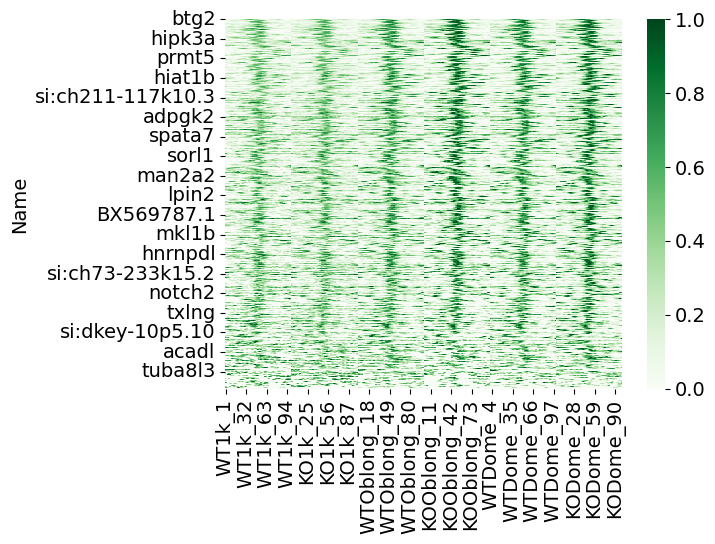

9e0142


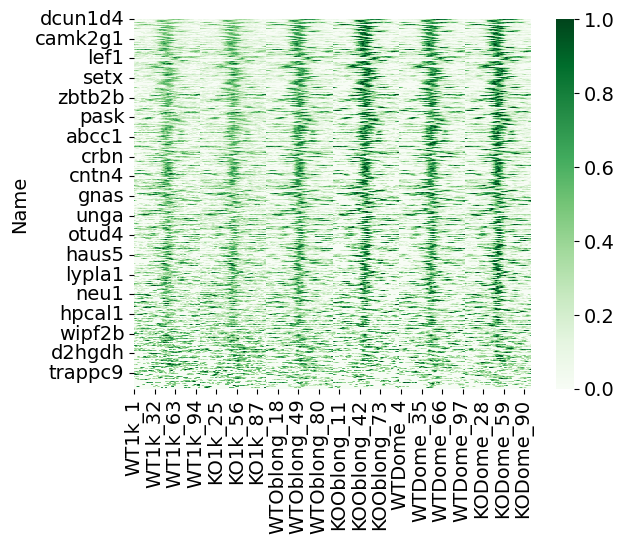

dd4a4c


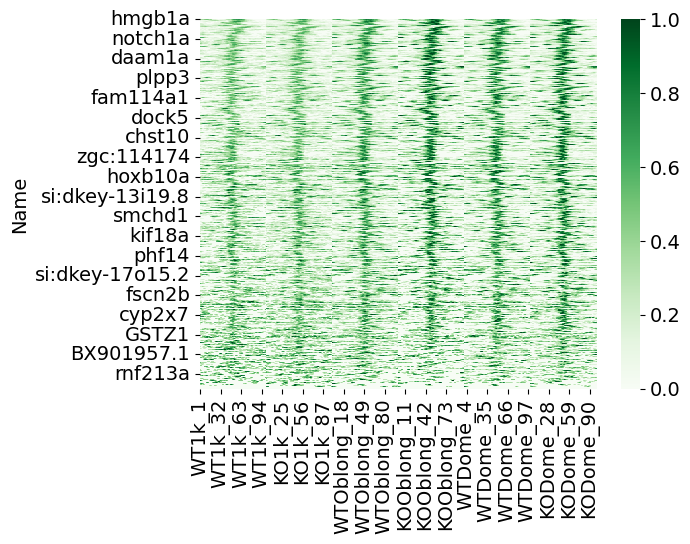

f98e52


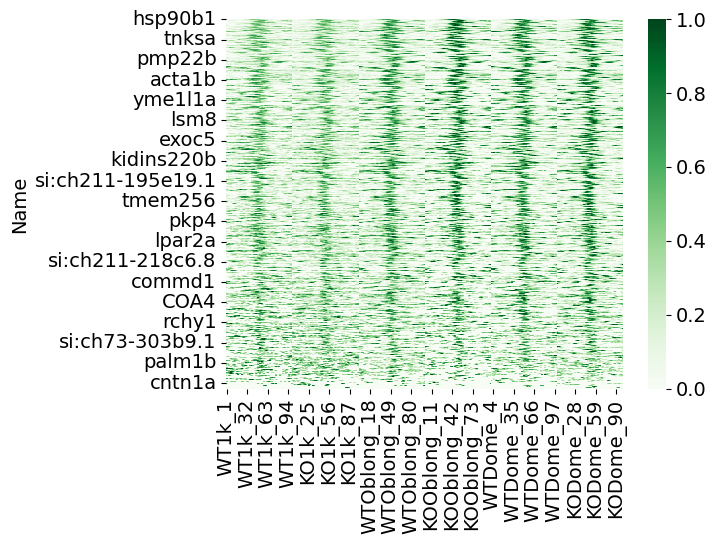

86cfa5


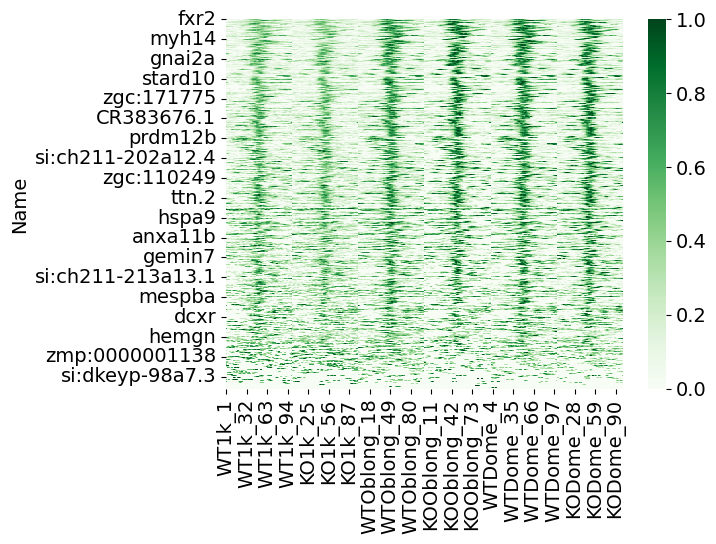

ffffbe


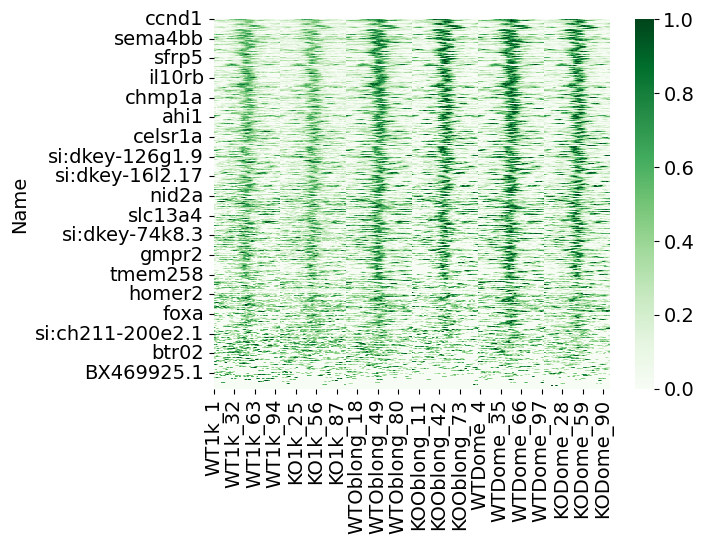

3d95b8


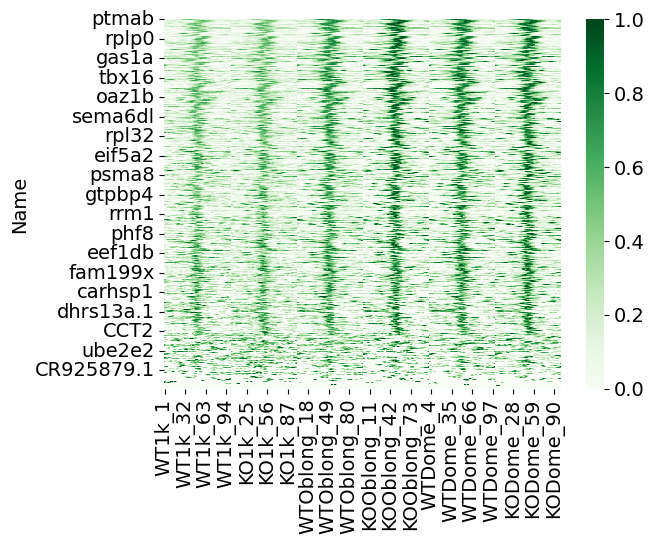

5e4fa2


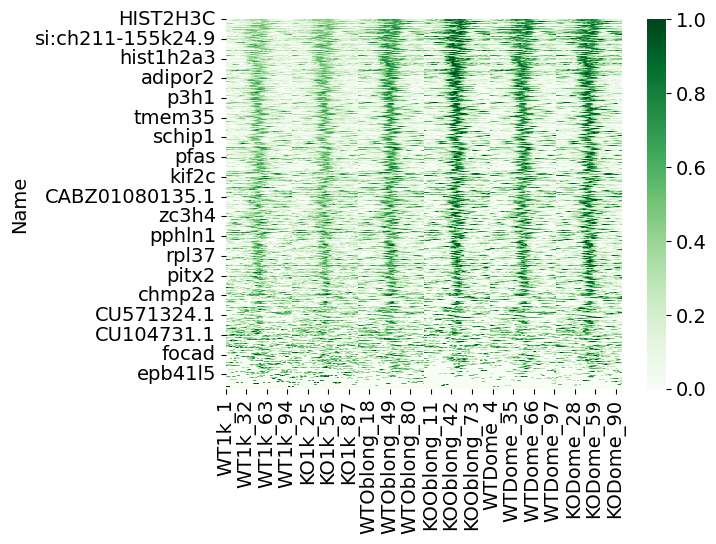

d6ee9b


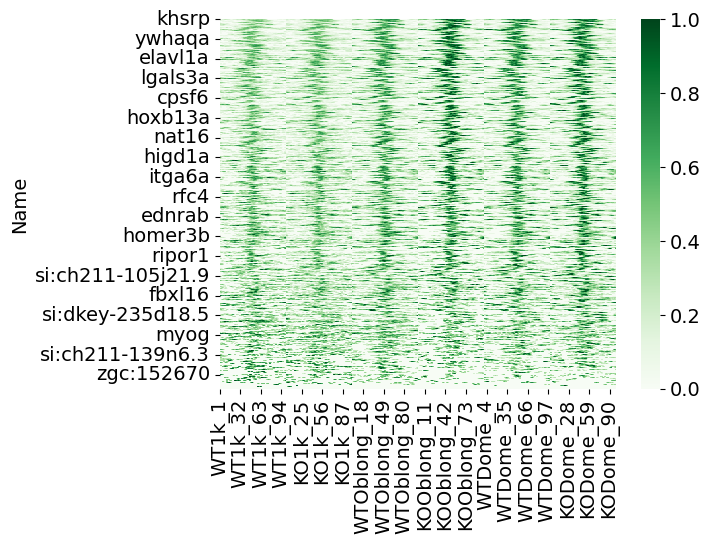

Silent


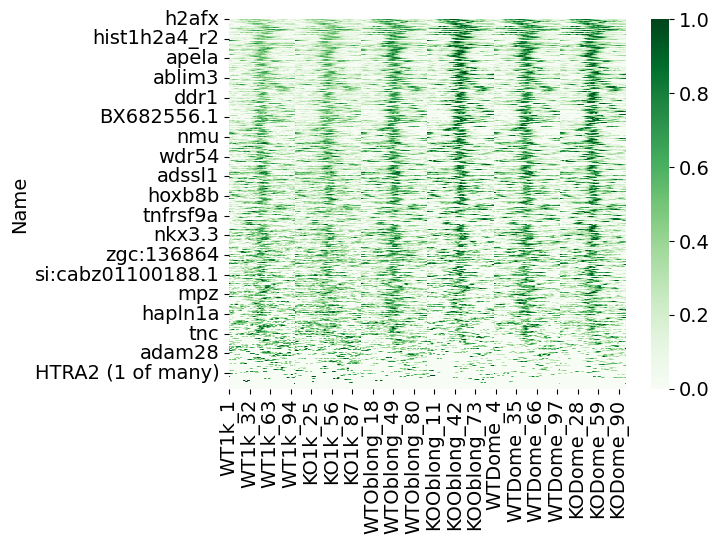

In [27]:
import itertools
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore

scaler = MinMaxScaler()

mean_rpkm = []
mods = []
conds = []
bins = 100
promoter_info_dfs = []

for mod in cluster_order:
    # Load module data
    data = pd.read_csv(f'{syncdir}/Deeptools_HVG_cluster_{mod}_data.tab.gz', skiprows=1, sep='\t', header=None)
    
    # Store peak info
    promoter_info = data.iloc[:,0:6]
    promoter_info.columns = ['Chromosome', 'Start', 'End', 'Name', 'Score', 'Strand']
    promoter_info.index = promoter_info.Name
    promoter_info['Module'] = mod
    promoter_info_dfs.append(promoter_info)

    # Remove peak info
    data = data.iloc[:,6:]
    data.index = promoter_info.Name    
    data
    
    # Make colnames (note needs to reflect order of bigwigs above)
    timepoint = ['1k', 'Oblong', 'Dome']
    condition = ['WT', 'KO']
    conditions = [''.join([i[1], i[0]]) for i in itertools.product(timepoint, condition)]
    data.columns = ['_'.join([i[0], str(i[1])]) for i in itertools.product(conditions, range(1, bins+1))]

    # Transform the data using sqrt
    data = np.sqrt(data)
    
    # Scale bins for each enhancer (row) of data
    data[data.columns.to_list()] = scaler.fit_transform(data[data.columns.to_list()].T).T
    print(mod)
    sns.heatmap(data, cmap='Greens')
    # sns.heatmap(data.loc[(data.iloc[:,data.columns.str.contains('KODome')].mean(axis=1)/data.iloc[:,data.columns.str.contains('WTDome')].mean(axis=1)).sort_values(ascending=True).index], cmap='Blues')
    plt.show()
    
    # Get mean for each group
    for cond in conditions:
        mean_rpkm.append(data.iloc[:,data.columns.str.contains(cond)].mean().mean())
        mods.append(mod)
        conds.append(cond)

# Create dataframe of summary stats
summary_stats = pd.DataFrame({'Module':mods, 'Condition':conds, 'Mean_RPKM':mean_rpkm})
summary_stats['Module'] = summary_stats['Module'].astype('category')
summary_stats['Module'] = summary_stats['Module'].cat.reorder_categories(cluster_order)
summary_stats['Condition'] = summary_stats['Condition'].astype('category')
# summary_stats['Condition'] = summary_stats['Condition'].cat.reorder_categories(['WT1k','KO1k', 'WTOblong', 'KOOblong', 'WTDome', 'KODome'])
summary_stats['Condition'] = summary_stats['Condition'].cat.reorder_categories(['WT1k','WTOblong', 'WTDome', 'KO1k', 'KOOblong', 'KODome'])


In [28]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# data = pd.read_csv(f'{syncdir}/GSPA_modules_genes_promoter_cluster10_data.tab.gz', skiprows=1, sep='\t', header=None)
# data.index = data[3]

# # Remove peak info
# data = data.iloc[:,6:]
# data

# # Make colnames (note needs to reflect order of bigwigs above)
# timepoint = ['1k', 'Oblong', 'Dome']
# condition = ['WT', 'KO']
# conditions = [''.join([i[1], i[0]]) for i in itertools.product(timepoint, condition)]
# data.columns = ['_'.join([i[0], str(i[1])]) for i in itertools.product(conditions, range(1, bins+1))]

# # Transform the data using sqrt
# data = np.sqrt(data)

# # Scale bins for each enhancer (row) of data
# # data[data.columns.to_list()] = scaler.fit_transform(data[data.columns.to_list()].T).T

# # Seperate panels of heatmaps
# sns.heatmap(data, square = False, cmap='Greens')

In [29]:
# Create dataframe of ATAC summary stats
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

result_promoter = summary_stats.pivot(columns='Condition', index='Module', values='Mean_RPKM')
# result_promoter[result_promoter.columns.to_list()] = scaler.fit_transform(result_promoter[result_promoter.columns.to_list()].T).T


<Figure size 600x1200 with 0 Axes>

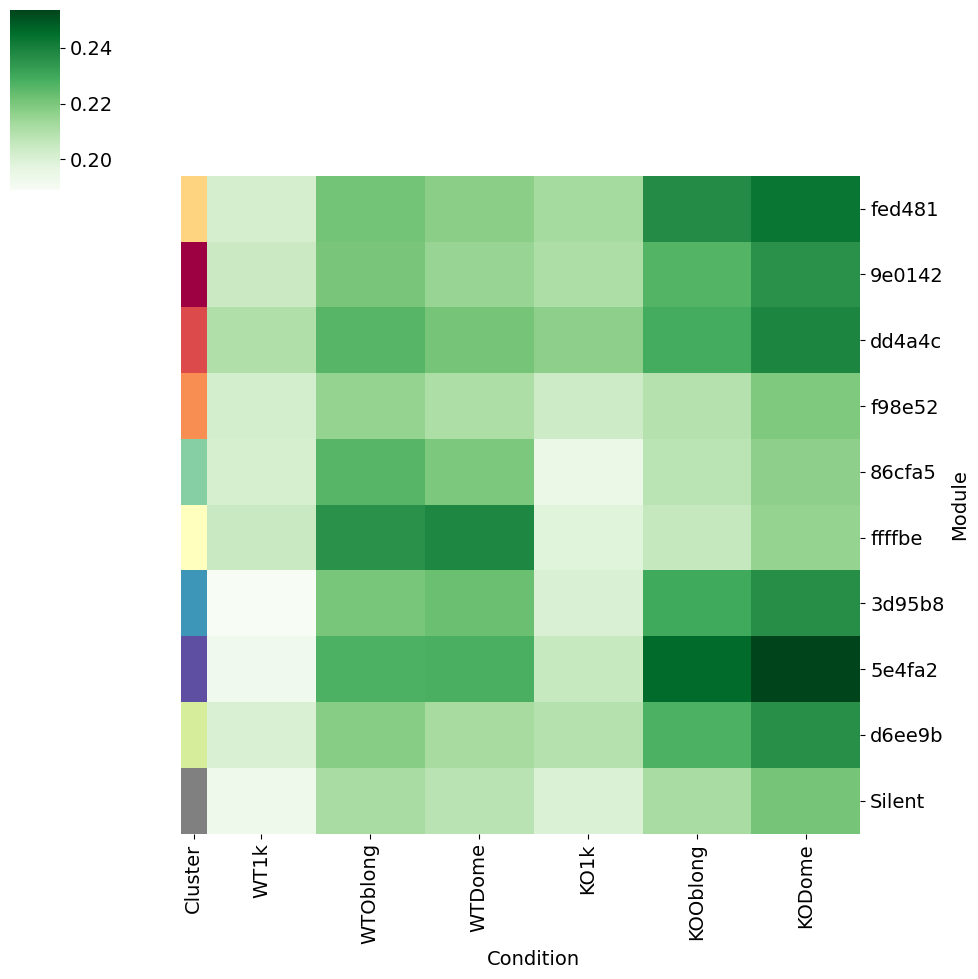

In [30]:
# Make heatmap and clip outlier values
# colour_max = result_promoter.stack().mean() + 2*result_promoter.stack().std()
# colour_min = result_promoter.stack().mean() - 2*result_promoter.stack().std()

colour_max = result_promoter.stack().quantile(.9)
colour_min = result_promoter.stack().quantile(.1)

plt.figure(figsize=(6, 12))
# ax = sns.heatmap(result_promoter, annot=False, cmap='Greens', yticklabels=True, square=True, vmin=colour_min, vmax=colour_max)
ax = sns.clustermap(result_promoter, annot=False, cmap='Greens', yticklabels=True, row_cluster=False, col_cluster=False, row_colors=colours)
plt.savefig(f'{syncdir}/scMZnps_HVG_cluster_Promoter_Accessibility_MZnps_timecourse.pdf')
plt.show()


fed481


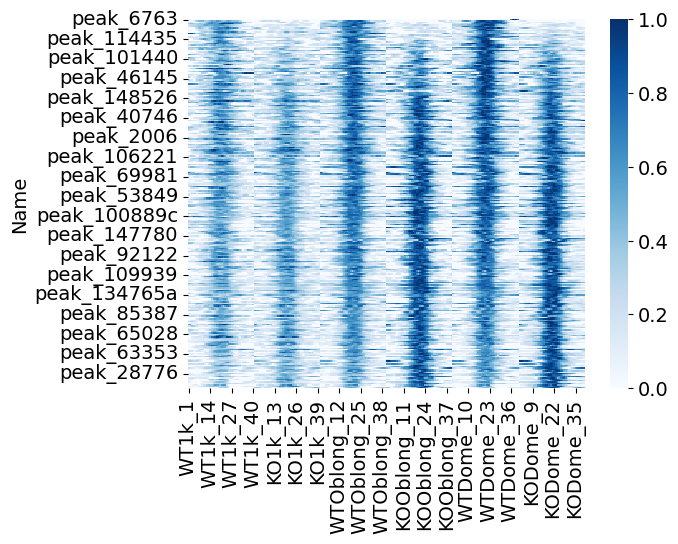

9e0142


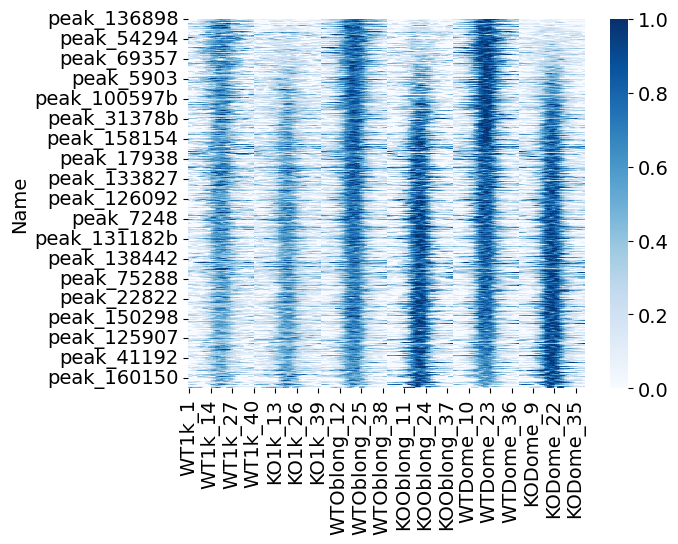

dd4a4c


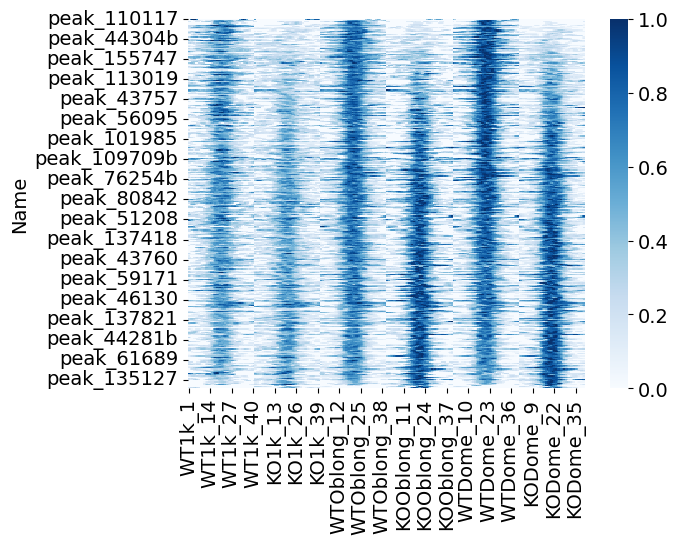

f98e52


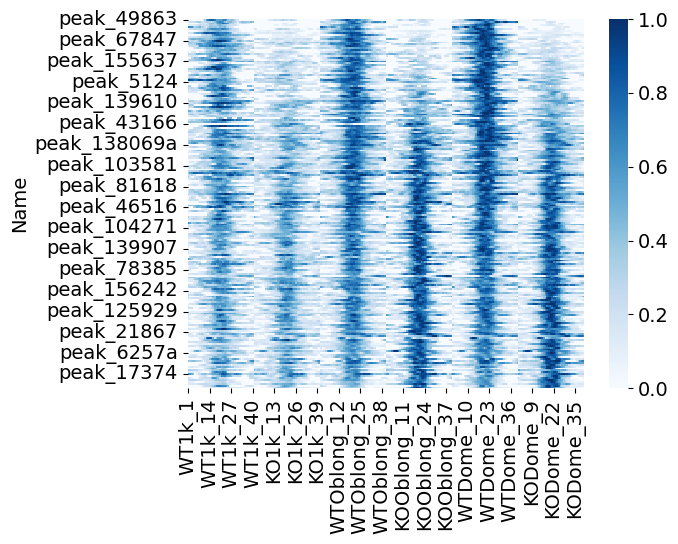

86cfa5


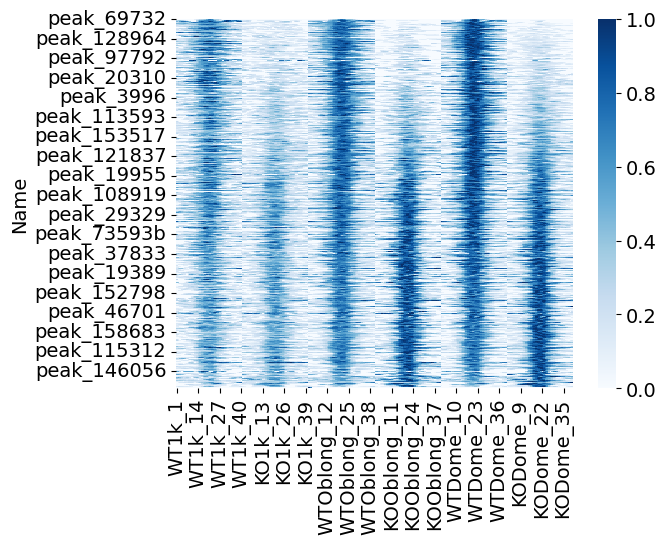

ffffbe


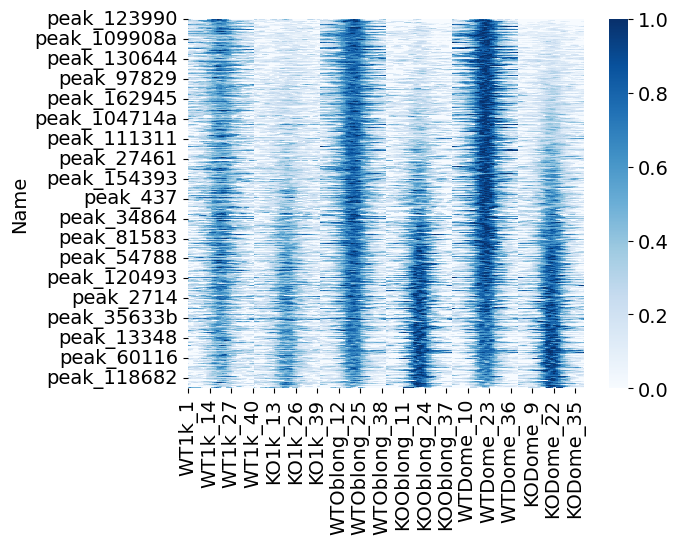

3d95b8


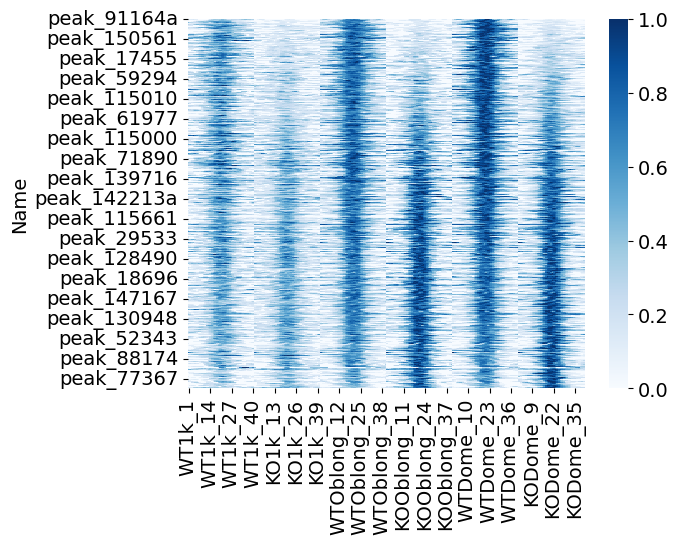

5e4fa2


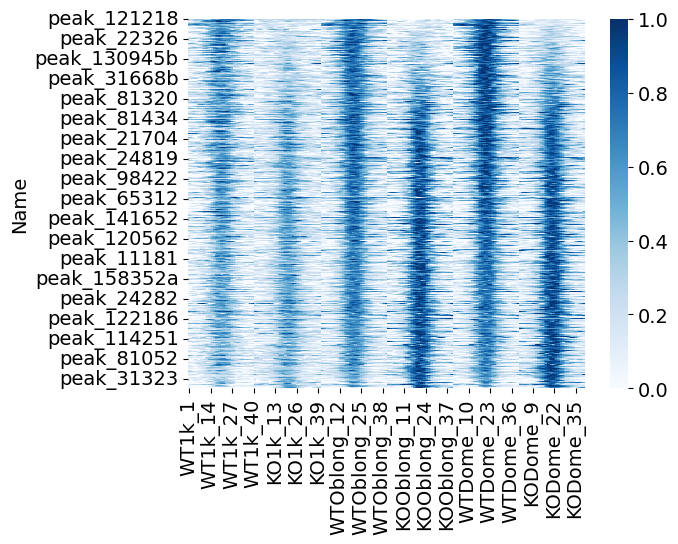

d6ee9b


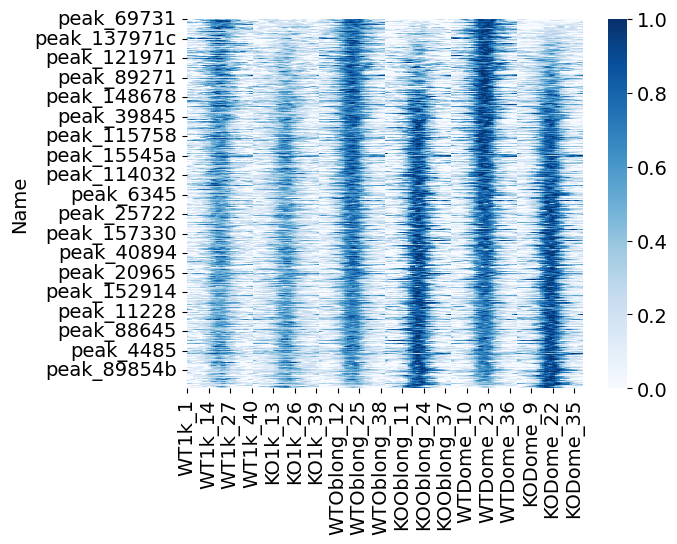

Silent


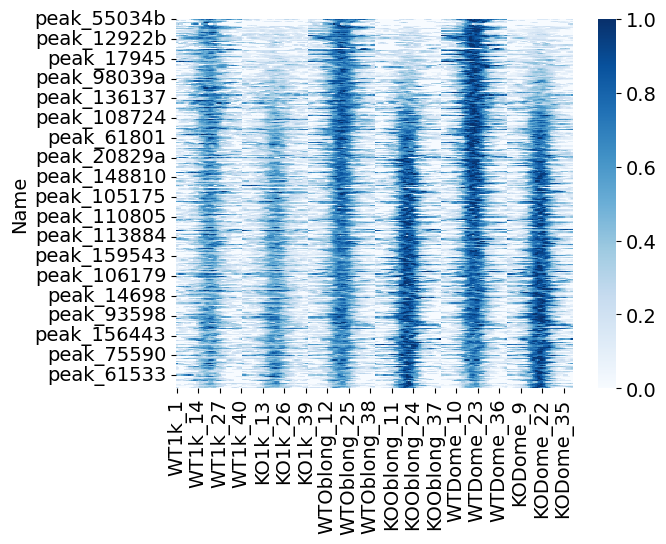

In [31]:
import itertools
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

enhancer_info_dfs = []
mean_rpkm = []
mods = []
conds = []
bins = 40

for mod in cluster_order:
    # Load module data
    data = pd.read_csv(f'{syncdir}/Deeptools_HVG_cluster_{mod}_enhancer_data.tab.gz', skiprows=1, sep='\t', header=None)

    # Store peak info
    enhancer_info = data.iloc[:,0:6]
    enhancer_info.columns = ['Chromosome', 'Start', 'End', 'Name', 'Score', 'Strand']
    enhancer_info.index = enhancer_info.Name
    enhancer_info['Module'] = mod
    enhancer_info_dfs.append(enhancer_info)

    # Remove peak info
    data = data.iloc[:,6:]
    data.index = enhancer_info.Name    
    data
    
    # Make colnames (note needs to reflect order of bigwigs above)
    timepoint = ['1k', 'Oblong', 'Dome']
    condition = ['WT', 'KO']
    conditions = [''.join([i[1], i[0]]) for i in itertools.product(timepoint, condition)]
    data.columns = ['_'.join([i[0], str(i[1])]) for i in itertools.product(conditions, range(1, bins+1))]

    # Transform the data using sqrt
    data = np.sqrt(data)

    # Calculate LFC between conditions at dome stage and use to order heatmap
    
    
    # Scale bins for each enhancer (row) of data
    data[data.columns.to_list()] = scaler.fit_transform(data[data.columns.to_list()].T).T
    print(mod)
    sns.heatmap(data.loc[(data.iloc[:,data.columns.str.contains('KODome')].mean(axis=1)/data.iloc[:,data.columns.str.contains('WTDome')].mean(axis=1)).sort_values(ascending=True).index], cmap='Blues')
    plt.show()
    
    # Get mean for each group
    for cond in conditions:
        mean_rpkm.append(data.iloc[:,data.columns.str.contains(cond)].mean().mean())
        mods.append(mod)
        conds.append(cond)

# Create dataframe of summary stats
summary_stats = pd.DataFrame({'Module':mods, 'Condition':conds, 'Mean_RPKM':mean_rpkm})
summary_stats['Module'] = summary_stats['Module'].astype('category')
summary_stats['Module'] = summary_stats['Module'].cat.reorder_categories(cluster_order)
summary_stats['Condition'] = summary_stats['Condition'].astype('category')
# summary_stats['Condition'] = summary_stats['Condition'].cat.reorder_categories(['WT1k','KO1k', 'WTOblong', 'KOOblong', 'WTDome', 'KODome'])
summary_stats['Condition'] = summary_stats['Condition'].cat.reorder_categories(['WT1k','WTOblong', 'WTDome', 'KO1k', 'KOOblong', 'KODome'])


In [32]:
# Create dataframe of ATAC summary stats
result_enhancer = summary_stats.pivot(columns='Condition', index='Module', values='Mean_RPKM')
# result_enhancer[result_enhancer.columns.to_list()] = scaler.fit_transform(result_enhancer[result_enhancer.columns.to_list()].T).T

<Figure size 600x1200 with 0 Axes>

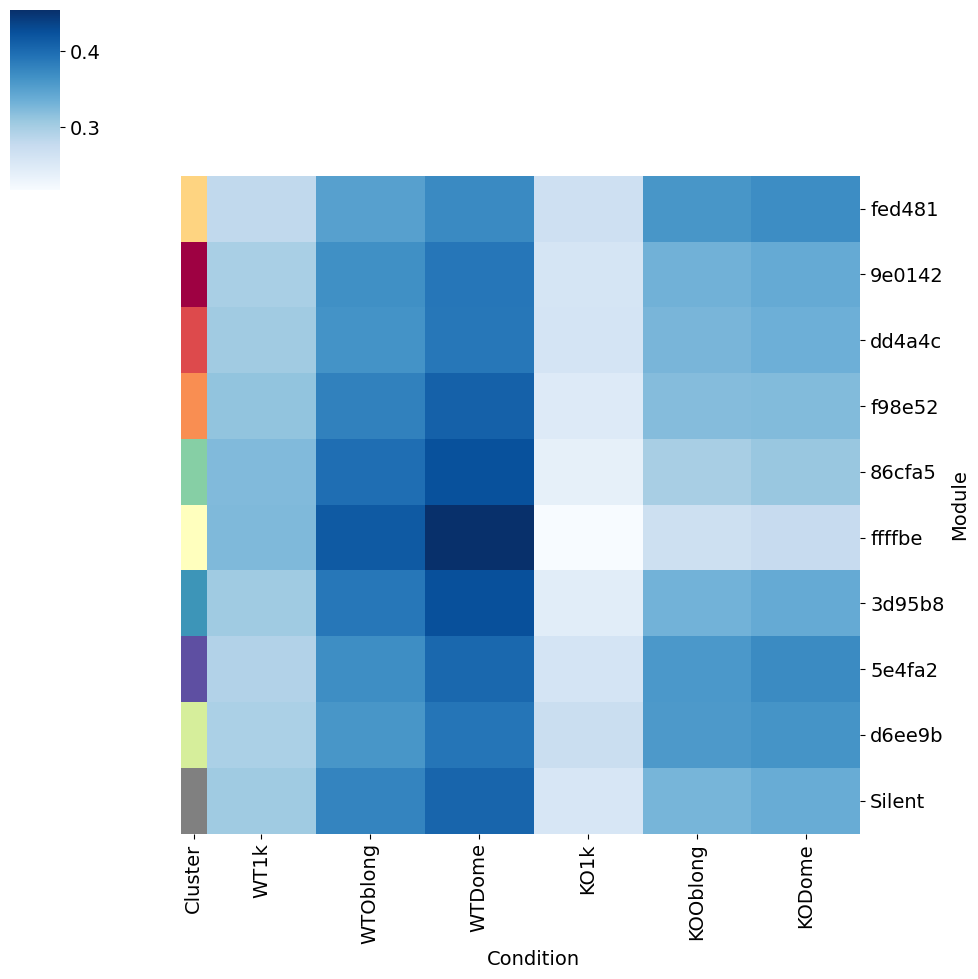

In [33]:
# Make heatmap and clip outlier values
# colour_max = result_enhancer.stack().mean() + 2*result_enhancer.stack().std()
# colour_min = result_enhancer.stack().mean() - 2*result_enhancer.stack().std()

colour_max = result_enhancer.stack().quantile(.9)
colour_min = result_enhancer.stack().quantile(.1)

plt.figure(figsize=(6, 12))
# ax = sns.heatmap(result_enhancer, annot=False, cmap='Blues', yticklabels=True, square=True, vmin=colour_min, vmax=colour_max)
ax = sns.clustermap(result_enhancer, annot=False, cmap='Blues', yticklabels=True, row_cluster=False, col_cluster=False, row_colors=colours)
plt.savefig(f'{syncdir}/scMZnps_HVG_cluster_Enhancer_Accessibility_MZnps_timecourse.pdf')
plt.show()


### Export promoters and enhancers to analyse TF binding

In [34]:
# Load enhancer info and save for analysis with MEME locally
atac_peaks.index = atac_peaks.peak
enhancer_info = pd.concat(enhancer_info_dfs, axis=0)
enhancer_info = enhancer_info.merge(atac_peaks, how='left', left_index=True, right_index=True)
enhancer_info.to_csv(f'{syncdir}/scMZnps_HVG_cluster_Enhancers.csv')

In [35]:
promoter_info = pd.concat(promoter_info_dfs, axis=0)
promoter_info

Chromosome     Start       End                  Name  \
Name                                                                        
btg2                      chr22    336072    336073                  btg2   
stt3b                     chr16  39477746  39477747                 stt3b   
gtf2a1                    chr20  16453603  16453604                gtf2a1   
mllt1a                     chr8  20230802  20230803                mllt1a   
per3                      chr11  39959038  39959039                  per3   
...                         ...       ...       ...                   ...   
si:dkey-125e8.4            chr7   2455343   2455344       si:dkey-125e8.4   
RF00004_r1                 chr2  14665167  14665168            RF00004_r1   
CR790366.2                 chr5  10719301  10719302            CR790366.2   
BX465208.1                 chr6  26572000  26572001            BX465208.1   
HTRA2 (1 of many)_r1      chr21   4410732   4410733  HTRA2 (1 of many)_r1   

                      Score Strand  Module  
Name                                        
btg2                    0.0      .  fed481  
stt3b                   0.0      .  fed481  
gtf2a1                  0.0      .  fed481  
mllt1a                  0.0      .  fed481  
per3                    0.0      .  fed481  
...                     ...    ...     ...  
si:dkey-125e8.4         0.0      .  Silent  
RF00004_r1              0.0      .  Silent  
CR790366.2              0.0      .  Silent  
BX465208.1              0.0      .  Silent  
HTRA2 (1 of many)_r1    0.0      .  Silent  

[8832 rows x 7 columns]

In [36]:
# Load enhancer info and save for analysis with MEME locally
atac_genes.index = atac_genes.gene_name
promoter_info = pd.concat(promoter_info_dfs, axis=0)
promoter_info = promoter_info.merge(atac_genes, how='left', left_index=True, right_index=True)
promoter_info.to_csv(f'{syncdir}/scMZnps_HVG_cluster_Promoters.csv')

### Analyse rescue across conditions for enhancer peaks

In [47]:
enhancer_info.columns

Index(['Chromosome', 'Start', 'End', 'Name', 'Score', 'Strand', 'Module',
       'peak', 'chr', 'start', 'end', 'summit', 'WT_3_rep_avg',
       'MZnps_3_rep_avg', 'WT_rescue', 'MZnps_rescue', 'Nanog_rescue',
       'Pou5f3_rescue', 'Sox19b_rescue (low)', 'Sox19b_rescue (high)',
       'NP_rescue', 'NS_rescue', 'PS_rescue', 'NPS_rescue', 'WT_dosage_rescue',
       'MZnps_dosage_rescue', 'Nanog_rescue (low)', 'Nanog_rescue (high)',
       'Pou5f3_rescue (low)', 'Pou5f3_rescue (high)', 'WT_sdt_mut', 'N-/P-/S-',
       'N+/P-/S-', 'N-/P+/S-', 'N+/P+/S-', 'N-/P+/S+_ATAC', 'N+/P+/S+',
       'Category', 'Location', 'seq'],
      dtype='object')

In [40]:
# cols = ['N-/P-/S-', 'N+/P-/S-', 'N-/P+/S-', 'N+/P+/S-', 'N-/P+/S+_ATAC', 'N+/P+/S+']
# cols = ['WT_rescue', 'MZnps_rescue', 'Nanog_rescue', 'Pou5f3_rescue', 'Sox19b_rescue (high)', 'NP_rescue', 'NS_rescue', 'PS_rescue', 'NPS_rescue']
# cols = ['WT_dosage_rescue', 'WT_rescue', 'MZnps_dosage_rescue', 'MZnps_rescue', 'Sox19b_rescue (low)', 'Sox19b_rescue (high)', 'Nanog_rescue', 'Nanog_rescue (low)', 'Nanog_rescue (high)', 'Pou5f3_rescue', 'Pou5f3_rescue (low)', 'Pou5f3_rescue (high)', 'NP_rescue', 'NS_rescue', 'PS_rescue', 'NPS_rescue']
# cols = ['WT_dosage_rescue', 'WT_rescue', 'MZnps_dosage_rescue', 'MZnps_rescue', 'N-/P-/S-', 'Sox19b_rescue (low)', 'Sox19b_rescue (high)', 'Nanog_rescue', 'Nanog_rescue (low)', 'Nanog_rescue (high)', 'N+/P-/S-', 'Pou5f3_rescue', 'Pou5f3_rescue (low)', 'Pou5f3_rescue (high)', 'N-/P+/S-', 'NP_rescue', 'N+/P+/S-', 'NS_rescue', 'PS_rescue', 'N-/P+/S+_ATAC', 'NPS_rescue', 'N+/P+/S+']
cols = ['WT_3_rep_avg', 'MZnps_3_rep_avg']

data_df = enhancer_info[[*cols, 'Module']][(enhancer_info['Location'] == "Active enhancer")].groupby('Module').mean()
data_df = data_df.T[cluster_order].T
data_df = data_df.drop(['Silent'], axis=0) 
data_df

WT_3_rep_avg  MZnps_3_rep_avg
Module                               
fed481      1.617304         1.895506
9e0142      1.526827         1.420560
dd4a4c      1.441824         1.251078
f98e52      1.524007         1.304146
86cfa5      1.652992         1.208223
ffffbe      1.803714         0.883130
3d95b8      1.866271         1.377530
5e4fa2      1.870987         1.934419
d6ee9b      1.620783         1.603830

<Figure size 600x1200 with 0 Axes>

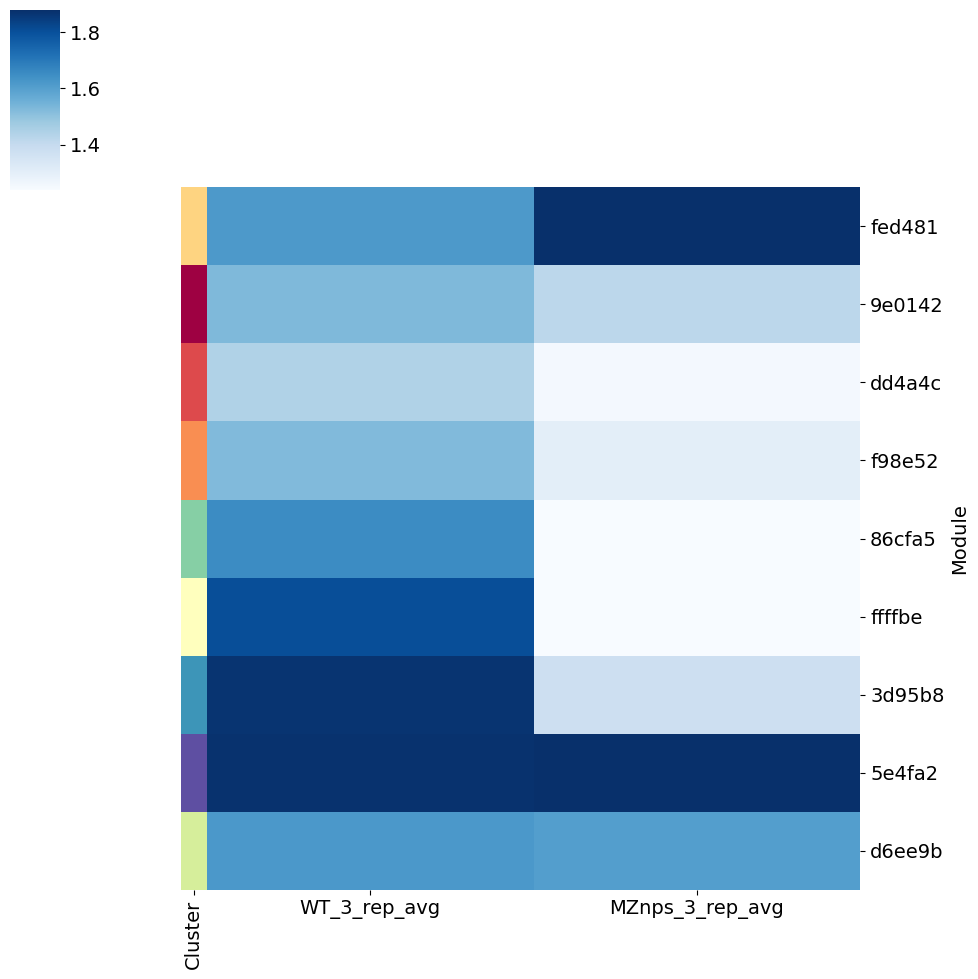

In [41]:
colour_max = data_df.stack().quantile(.9)
colour_min = data_df.stack().quantile(.1)

plt.figure(figsize=(6, 12))
ax = sns.clustermap(data_df, annot=False, cmap='Blues', yticklabels=True, row_cluster=False, col_cluster=False, vmin=colour_min, vmax=colour_max, row_colors=colours)
# ax = sns.clustermap(data_df, annot=False, cmap='Blues', yticklabels=True, standard_scale=0, row_cluster=False, col_cluster=False)
# ax = sns.heatmap(data_df, annot=False, cmap='Blues', yticklabels=True, square=True)
plt.savefig(f'{syncdir}/scMZnps_HVG_cluster_Active_Enhancer_Accessibility_MZnps_Liyun_data.pdf')
plt.show()


In [42]:
# cols = ['N-/P-/S-', 'N+/P-/S-', 'N-/P+/S-', 'N+/P+/S-', 'N-/P+/S+_ATAC', 'N+/P+/S+']
cols = ['WT_rescue', 'MZnps_rescue', 'Nanog_rescue', 'Pou5f3_rescue', 'Sox19b_rescue (low)', 'Sox19b_rescue (high)', 'NP_rescue', 'NS_rescue', 'PS_rescue', 'NPS_rescue']
# cols = ['WT_dosage_rescue', 'WT_rescue', 'MZnps_dosage_rescue', 'MZnps_rescue', 'Sox19b_rescue (low)', 'Sox19b_rescue (high)', 'Nanog_rescue', 'Nanog_rescue (low)', 'Nanog_rescue (high)', 'Pou5f3_rescue', 'Pou5f3_rescue (low)', 'Pou5f3_rescue (high)', 'NP_rescue', 'NS_rescue', 'PS_rescue', 'NPS_rescue']
# cols = ['WT_dosage_rescue', 'WT_rescue', 'MZnps_dosage_rescue', 'MZnps_rescue', 'N-/P-/S-', 'Sox19b_rescue (low)', 'Sox19b_rescue (high)', 'Nanog_rescue', 'Nanog_rescue (low)', 'Nanog_rescue (high)', 'N+/P-/S-', 'Pou5f3_rescue', 'Pou5f3_rescue (low)', 'Pou5f3_rescue (high)', 'N-/P+/S-', 'NP_rescue', 'N+/P+/S-', 'NS_rescue', 'PS_rescue', 'N-/P+/S+_ATAC', 'NPS_rescue', 'N+/P+/S+']
# cols = ['WT_3_rep_avg', 'MZnps_3_rep_avg']

data_df = enhancer_info[[*cols, 'Module']][(enhancer_info['Location'] == "Active enhancer")].groupby('Module').mean()
data_df = data_df.T[cluster_order].T
data_df = data_df.drop(['Silent'], axis=0) 
data_df

WT_rescue  MZnps_rescue  Nanog_rescue  Pou5f3_rescue  \
Module                                                         
fed481   2.056709      2.072864      1.789070       1.945733   
9e0142   1.952254      1.517774      1.500090       1.428887   
dd4a4c   1.855903      1.378236      1.394762       1.322467   
f98e52   1.963310      1.397529      1.604832       1.336617   
86cfa5   2.084025      1.315839      1.437700       1.273854   
ffffbe   2.319269      0.952238      1.362601       0.981950   
3d95b8   2.392943      1.516979      1.631785       1.511568   
5e4fa2   2.384456      2.112094      1.958958       2.052599   
d6ee9b   2.079447      1.752625      1.660808       1.695866   

        Sox19b_rescue (low)  Sox19b_rescue (high)  NP_rescue  NS_rescue  \
Module                                                                    
fed481             1.933229              2.142882   1.922453   1.964683   
9e0142             1.486823              1.738965   1.682812   1.743650   
dd4a4c             1.349788              1.589897   1.565460   1.631995   
f98e52             1.381295              1.624829   1.774092   1.842958   
86cfa5             1.277620              1.551002   1.704473   1.686210   
ffffbe             0.981606              1.279652   1.801832   1.694673   
3d95b8             1.491272              1.897404   1.928619   1.971965   
5e4fa2             2.044940              2.448255   2.163785   2.267370   
d6ee9b             1.713407              2.078367   1.836886   1.932972   

        PS_rescue  NPS_rescue  
Module                         
fed481   2.137950    2.110136  
9e0142   1.627538    1.925741  
dd4a4c   1.475400    1.779211  
f98e52   1.473052    2.003729  
86cfa5   1.438211    1.993219  
ffffbe   1.182834    2.194913  
3d95b8   1.731680    2.270477  
5e4fa2   2.254801    2.447247  
d6ee9b   1.877644    2.084635

<Figure size 600x1200 with 0 Axes>

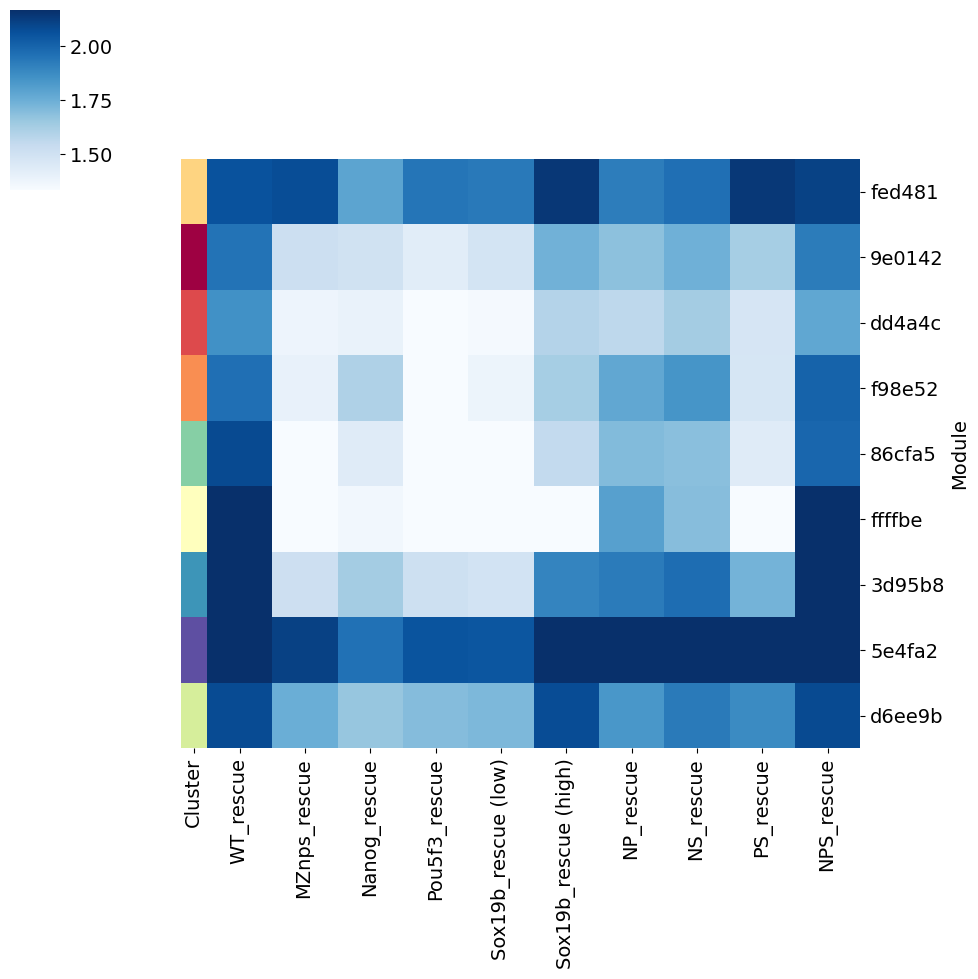

In [43]:
colour_max = data_df.stack().quantile(.9)
colour_min = data_df.stack().quantile(.1)

plt.figure(figsize=(6, 12))
ax = sns.clustermap(data_df, annot=False, cmap='Blues', yticklabels=True, row_cluster=False, col_cluster=False, vmin=colour_min, vmax=colour_max, row_colors=colours)
# ax = sns.clustermap(data_df, annot=False, cmap='Blues', yticklabels=True, standard_scale=0, row_cluster=False, col_cluster=False)
# ax = sns.heatmap(data_df, annot=False, cmap='Blues', yticklabels=True, square=True)
plt.savefig(f'{syncdir}/scMZnps_HVG_cluster_Active_Enhancer_Rescue_MZnps_Liyun_data.pdf')
plt.show()


In [44]:
cols = ['N-/P-/S-', 'N+/P-/S-', 'N-/P+/S-', 'N+/P+/S-', 'N-/P+/S+_ATAC', 'N+/P+/S+']
# cols = ['WT_rescue', 'MZnps_rescue', 'Nanog_rescue', 'Pou5f3_rescue', 'Sox19b_rescue (high)', 'NP_rescue', 'NS_rescue', 'PS_rescue', 'NPS_rescue']
# cols = ['WT_dosage_rescue', 'WT_rescue', 'MZnps_dosage_rescue', 'MZnps_rescue', 'Sox19b_rescue (low)', 'Sox19b_rescue (high)', 'Nanog_rescue', 'Nanog_rescue (low)', 'Nanog_rescue (high)', 'Pou5f3_rescue', 'Pou5f3_rescue (low)', 'Pou5f3_rescue (high)', 'NP_rescue', 'NS_rescue', 'PS_rescue', 'NPS_rescue']
# cols = ['WT_dosage_rescue', 'WT_rescue', 'MZnps_dosage_rescue', 'MZnps_rescue', 'N-/P-/S-', 'Sox19b_rescue (low)', 'Sox19b_rescue (high)', 'Nanog_rescue', 'Nanog_rescue (low)', 'Nanog_rescue (high)', 'N+/P-/S-', 'Pou5f3_rescue', 'Pou5f3_rescue (low)', 'Pou5f3_rescue (high)', 'N-/P+/S-', 'NP_rescue', 'N+/P+/S-', 'NS_rescue', 'PS_rescue', 'N-/P+/S+_ATAC', 'NPS_rescue', 'N+/P+/S+']
# cols = ['WT_3_rep_avg', 'MZnps_3_rep_avg']

data_df = enhancer_info[[*cols, 'Module']][(enhancer_info['Location'] == "Active enhancer")].groupby('Module').mean()
data_df = data_df.T[cluster_order].T
data_df = data_df.drop(['Silent'], axis=0) 
data_df

N-/P-/S-  N+/P-/S-  N-/P+/S-  N+/P+/S-  N-/P+/S+_ATAC  N+/P+/S+
Module                                                                 
fed481  2.157043  2.065833  2.210402  1.972166       1.619597  2.121785
9e0142  1.513298  1.653174  1.592564  1.586657       1.255674  1.776918
dd4a4c  1.316203  1.441509  1.382924  1.349036       1.062064  1.532591
f98e52  1.355045  1.650933  1.419690  1.643199       1.063685  1.722360
86cfa5  1.361332  1.525807  1.414551  1.546695       1.141714  1.791458
ffffbe  0.931224  1.326347  1.049376  1.468952       1.035989  1.800982
3d95b8  1.474292  1.814864  1.622208  1.841496       1.358126  2.083178
5e4fa2  2.367715  2.360541  2.469432  2.312815       1.791219  2.519645
d6ee9b  1.833649  1.952072  1.948422  1.871859       1.453752  2.029372

<Figure size 600x1200 with 0 Axes>

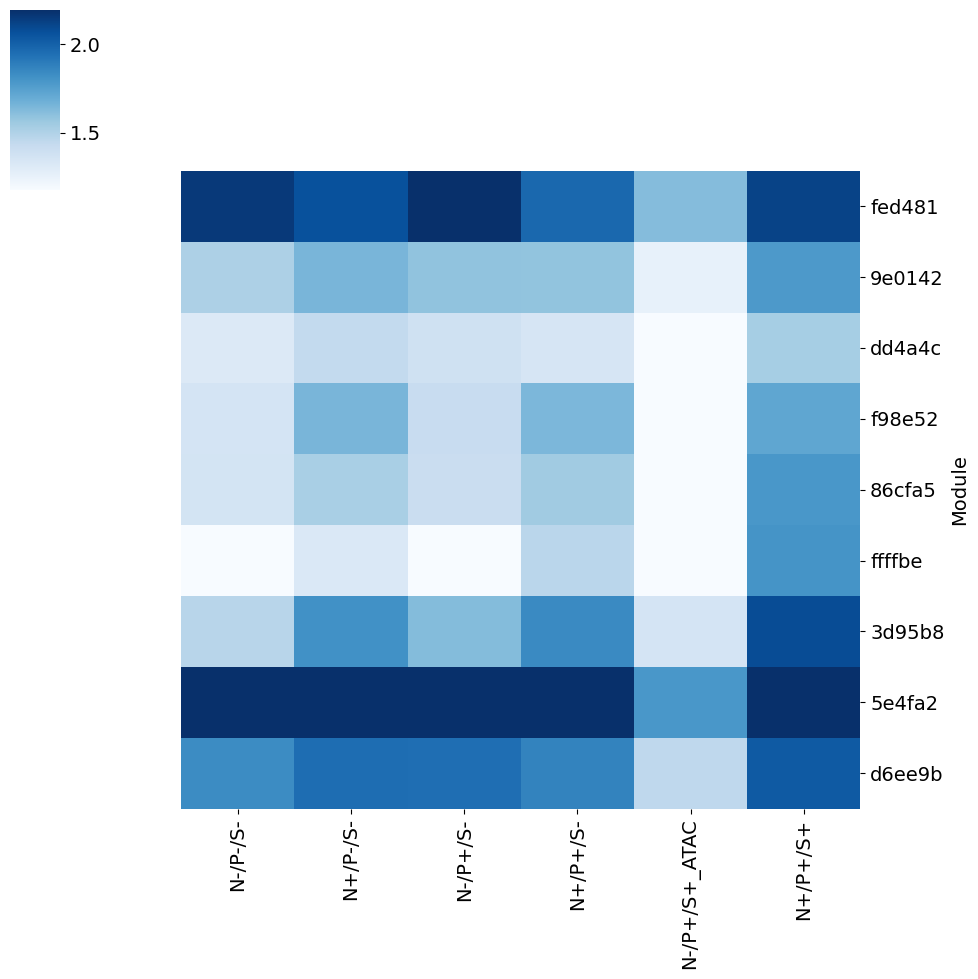

In [45]:
colour_max = data_df.stack().quantile(.9)
colour_min = data_df.stack().quantile(.1)

plt.figure(figsize=(6, 12))
ax = sns.clustermap(data_df, annot=False, cmap='Blues', yticklabels=True, row_cluster=False, col_cluster=False, vmin=colour_min, vmax=colour_max)
# ax = sns.clustermap(data_df, annot=False, cmap='Blues', yticklabels=True, standard_scale=0, row_cluster=False, col_cluster=False)
# ax = sns.heatmap(data_df, annot=False, cmap='Blues', yticklabels=True, square=True)
plt.savefig(f'{syncdir}/scMZnps_HVG_cluster_Active_Enhancer_123_Mutants_MZnps_Liyun_data.pdf')
plt.show()


In [ ]:
raise SystemExit("Relaxing...")